In [1]:
import numpy as np
import torch
import requests
from PIL import Image
import matplotlib.pyplot as plt
import torchvision


# MNIST

recognizing hand written digits

downloading the data set

In [2]:
# code here is taken from https://nextjournal.com/gkoehler/pytorch-mnist
batch_size_train = 64
batch_size_test = 1000
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=batch_size_test, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Recognizing handwritten digits

This section trains a model using different methods to acheieve high accuracy (metric) for recognizing the handwritten digits.

The data will be divided into 3 sections :
1. training data
2. validating data
3. test data






### Method 1 


Calculating the avg of all the same-digit-label images, then given an input image, we decide which digit it represent according to the min distance from the avg image.

In [3]:
# taking the avg per digit of the training set

print(type(train_loader.dataset[0][0]))
print(len(train_loader.dataset))

avgs = [torch.zeros(size=(28,28)) for i in range(10)]
counts = [0 for i in range(10)]

for image, label in train_loader.dataset:
  image = torch.squeeze(image)
  avgs[label] = torch.stack([avgs[label], image]).sum(dim=0)
  counts[label] += 1

for i in range(10):
   avgs[i] *= 1/counts[i]


<class 'torch.Tensor'>
60000


plotting the avg

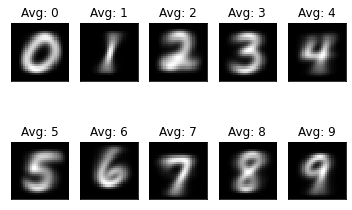

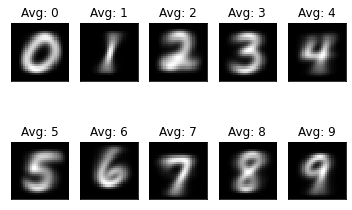

In [4]:

fig = plt.figure()
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(avgs[i], cmap='gray', interpolation='none')
  plt.title("Avg: {}".format(i))
  plt.xticks([])
  plt.yticks([])
fig

Now that we have the average of each image, we can determine for each image in the test data set what digit it represents according to its minimal distance from any of the average images.

Will test both L1 and L2 distance calculations and compare the accuracy of the model.

In [5]:
def L1(image):
  return [(image - avgs[i]).abs().mean().item() for i in range(10)]

def L2(image):
  return [torch.sqrt(torch.pow((image - avgs[i]), 2).mean()).item() for i in range(10)]

def predict(dists):
  return np.argsort(dists, axis=0)[0]


l1_dists = L1(train_loader.dataset[0][0])
l2_dists = L2(train_loader.dataset[0][0])
print('L1 for 1st item in trainer dataset: ', l1_dists, 'label: ', train_loader.dataset[0][1])
print('L2 for 1st item in trainer dataset: ',l2_dists)
print('model prediction using L1, L2:', predict(l1_dists), predict(l2_dists))


L1 for 1st item in trainer dataset:  [0.16943226754665375, 0.13352370262145996, 0.1639411896467209, 0.13608457148075104, 0.16499747335910797, 0.1334165632724762, 0.1561395823955536, 0.14413666725158691, 0.14566762745380402, 0.14975249767303467] label:  5
L2 for 1st item in trainer dataset:  [0.2904532849788666, 0.29626545310020447, 0.28313082456588745, 0.24634882807731628, 0.30586007237434387, 0.23909679055213928, 0.2848289906978607, 0.2784634530544281, 0.26365649700164795, 0.2821143567562103]
model prediction using L1, L2: 5 5


Applying the L1, L2 dist from the avg image over the test data and calculating the overall accuracy of the model.

In [6]:

l1_predictions = [0.0 for i in range(10)]
l2_predictions = [0.0 for i in range(10)]
counts = [0 for i in range(10)]
for image, label in test_loader.dataset:
  counts[label] += 1
  if predict(L1(image)) == label:
    l1_predictions[label] += 1
  if predict(L2(image)) == label:
    l2_predictions[label] += 1

l1_accuracy = [l1_predictions[i]/counts[i] for i in range(10)]
l2_accuracy = [l2_predictions[i]/counts[i] for i in range(10)]
print('L1 predications accuracy per digit: ', l1_accuracy)
print('L2 predications accuracy per digit: ', l2_accuracy)
print('L1 accuracy: ', np.sum(l1_accuracy)/10)
print('L2 accuracy: ', np.sum(l2_accuracy)/ 10)


L1 predications accuracy per digit:  [0.8153061224489796, 0.9982378854625551, 0.42344961240310075, 0.6089108910891089, 0.6680244399185336, 0.32623318385650224, 0.7870563674321504, 0.7645914396887159, 0.44250513347022585, 0.77601585728444]
L2 predications accuracy per digit:  [0.8959183673469387, 0.9621145374449339, 0.7567829457364341, 0.805940594059406, 0.8258655804480651, 0.6860986547085202, 0.8632567849686847, 0.8326848249027238, 0.7371663244353183, 0.8067393458870169]
L1 accuracy:  0.6610330933054313
L2 accuracy:  0.8172567959938041


**Follow up:**

changing how the data is segmented, and here it'll be according to folds, but since the avg might not be exact (because will be taking less images in order to calc it), i'll use KNN and see how the accuracy will change.


### Method 2

Using nueral network - will flaten the image s.t. each pixel will be a nueron.
This network will have 10 outputs, where each output corresponds to the propability of the image being a certain digit (according to the index of the output), meaning out put 9 will have the probability for the input image being a 9.

The ReLU will be used as the non-linearity activation for the first layer and in order to get the outputs all between 0 and 1 (to represent probability) as well as sum to 1, will use softmax

In [7]:
net = torch.nn.Sequential(
    torch.nn.Flatten(start_dim=1),
    torch.nn.Linear(28*28, 30), 
    torch.nn.ReLU(), 
    torch.nn.Linear(30, 10),
    torch.nn.Softmax()
)
print(net)
optim = torch.optim.SGD(net.parameters(), lr=0.05)
loss_func = torch.nn.CrossEntropyLoss()

input_t = train_loader.dataset[0][0].unsqueeze(0)
label = train_loader.dataset[0][1]
print('label', label, type(label), 'input_t shape', input_t.shape)

for i in range(13):
  output = net(input_t)
  loss = loss_func(output, torch.tensor([label]))
  optim.zero_grad()
  loss.backward()
  optim.step()
output


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=30, bias=True)
  (2): ReLU()
  (3): Linear(in_features=30, out_features=10, bias=True)
  (4): Softmax(dim=None)
)
label 5 <class 'int'> input_t shape torch.Size([1, 1, 28, 28])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[0.1234, 0.0924, 0.0806, 0.0952, 0.1084, 0.1553, 0.1154, 0.0602, 0.0897,
         0.0795]], grad_fn=<SoftmaxBackward>)

### Method 3

Using CNN 

In [8]:
features_to_track  = 32
model = torch.nn.Sequential(
    # first cnn layer with a 3x3 filter, thus it outputs a tensor of size 26.
    # since the image is grayscale, the in_channels is 1.
    torch.nn.Conv2d(in_channels=1, out_channels=32,kernel_size=3,stride=1),
    # torch.nn.ReLU(),

    # max poolin with stride of 2, therefor it downsample by x2 each dim of the image
    torch.nn.MaxPool2d(2,2),

    torch.nn.Flatten(),

    torch.nn.Linear(in_features=5408, out_features=100),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=100, out_features=20),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=20, out_features=10),
    torch.nn.Sigmoid(),
)
loss_fn= torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)

epochs = 150

for _ in range(epochs):
  for train_img_batch, train_label_batch in train_loader:
    # predict
    predictions = model(train_img_batch)

    # loss
    loss = loss_fn(predictions, train_label_batch)

    # backward 
    optim.zero_grad()
    loss.backward()
    
    # step (update params)
    optim.step()



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test the model after training for few epochs

In [9]:
def predict(img):
  predictions = model(img.unsqueeze(0))
  return np.argsort(predictions.detach().numpy()[0], axis=0)[-1]

print('label', test_loader.dataset[1001][1])
print('prediction', predict(test_loader.dataset[1001][0]))

wrong_guess_count = 0
for img_test, label in test_loader.dataset:
  if label != predict(img_test):
    wrong_guess_count += 1
print('wrong guesses', wrong_guess_count, wrong_guess_count/len(test_loader.dataset))

label 0
prediction 0
wrong guesses 153 0.0153


### Test with random handwriting

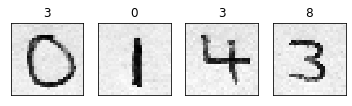

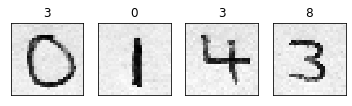

In [10]:
import cv2 as cv 
from skimage import io
from google.colab.patches import cv2_imshow

url = 'https://user-images.githubusercontent.com/40036314/48663507-57567a00-eab7-11e8-822e-ac80eace819b.jpg'
image = io.imread(url) 
image_2 = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

digits = [
          image_2[208:340, 560:660], 
          image_2[170:320, 120:230], 
          image_2[200:340, 454:550], 
          image_2[180:320, 225:360]
        ]
resized = [cv.resize(d, (28,28)) for d in digits]
tensors = [torch.tensor(d).unsqueeze(0)/255 for d in resized]
fig = plt.figure()
for i, t in enumerate(tensors):
  plt.subplot(1,4,i+1)
  plt.imshow(t.squeeze(), cmap='gray', interpolation='none')
  plt.title(predict(t))
  plt.xticks([])
  plt.yticks([])
fig


terrible results..I'll attempt to fix that by reducing the intensity of the background, as now it's not exactly white, so will create a low-pass-filter:
all intensities between white and gray will become white

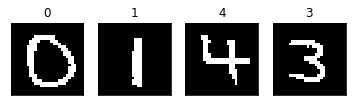

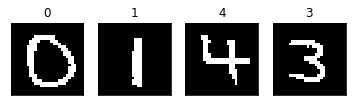

In [11]:
def filter_gray(img):
  img_filtered =  np.where(img > 175 , 255, img)
  return np.where(img_filtered == 255, 0 , 255)
  


resized = [cv.resize(d, (28,28)) for d in digits]
filtered = [filter_gray(img) for img in resized]
tensors = [torch.tensor(d).unsqueeze(0)/255 for d in filtered]

fig = plt.figure()
for i, t in enumerate(tensors):
  plt.subplot(1,4,i+1)
  plt.imshow(t.squeeze(), cmap='gray', interpolation='none')
  plt.title(predict(t))
  plt.xticks([])
  plt.yticks([])
fig
